this notebook is made for
1. leanrning how to check ckpt files
2. seeing if finetuning changes the base values

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#make sure youre using the corredct kernel!
import logging
class yAwareCLModel:

    def __init__(self, net, loss, loader_train, loader_val, loader_test, config, task_name, train_num, layer_control, n_iter, pretrained_path, scheduler=None): # ADNI
        """
        Parameters
        ----------
        net: subclass of nn.Module
        loss: callable fn with args (y_pred, y_true)
        loader_train, loader_val: pytorch DataLoaders for training/validation
        config: Config object with hyperparameters
        scheduler (optional)
        """
        super().__init__()
        self.logger = logging.getLogger("yAwareCL")

In [3]:
def load_model(self, path):
    checkpoint = None
    try:
        checkpoint = torch.load(path, map_location=lambda storage, loc: storage)
    except BaseException as e:
        self.logger.error('Impossible to load the checkpoint: %s' % str(e))
    if checkpoint is not None:
        try:
            if hasattr(checkpoint, "state_dict"):
                unexpected = self.model.load_state_dict(checkpoint.state_dict())
                self.logger.info('Model loading info: {}'.format(unexpected))
            elif isinstance(checkpoint, dict):
                if "model" in checkpoint:
                    unexpected = self.model.load_state_dict(checkpoint["model"], strict=False)
                    self.logger.info('Model loading info: {}'.format(unexpected))
            else:
                unexpected = self.model.load_state_dict(checkpoint)
                self.logger.info('Model loading info: {}'.format(unexpected))
        except BaseException as e:
            raise ValueError('Error while loading the model\'s weights: %s' % str(e))

In [4]:
import torch
import logging

#### 1. just testing some example of loading a pth file

In [5]:

pth_path =  './junbeom_finetuning/weights/DenseNet121_BHB-10K_yAwareContrastive.pth'
#load_model(yAwareCLModel(), path = pth_path)


In [6]:
!export CUDA_LAUNCH_BLOCKING=1
a = torch.load(pth_path)

a.keys()

dict_keys(['fold', 'epoch', 'model', 'optimizer'])

In [7]:
a['fold'], a['epoch']

(0, 30)

In [8]:
a['model'].keys()#10개만 보자

odict_keys(['module.features.conv0.weight', 'module.features.norm0.weight', 'module.features.norm0.bias', 'module.features.norm0.running_mean', 'module.features.norm0.running_var', 'module.features.norm0.num_batches_tracked', 'module.features.denseblock1.denselayer1.norm1.weight', 'module.features.denseblock1.denselayer1.norm1.bias', 'module.features.denseblock1.denselayer1.norm1.running_mean', 'module.features.denseblock1.denselayer1.norm1.running_var', 'module.features.denseblock1.denselayer1.norm1.num_batches_tracked', 'module.features.denseblock1.denselayer1.conv1.weight', 'module.features.denseblock1.denselayer1.norm2.weight', 'module.features.denseblock1.denselayer1.norm2.bias', 'module.features.denseblock1.denselayer1.norm2.running_mean', 'module.features.denseblock1.denselayer1.norm2.running_var', 'module.features.denseblock1.denselayer1.norm2.num_batches_tracked', 'module.features.denseblock1.denselayer1.conv2.weight', 'module.features.denseblock1.denselayer2.norm1.weight', 'm

In [9]:
a['optimizer'].keys()

dict_keys(['state', 'param_groups'])

### 2. checking if resnet changes

#### 2.1. BT resnent 보기 (note that didn't use the full checkpoint, as oppose to 2.2

In [37]:
org_pth = "/scratch/connectome/dyhan316/VAE_ADHD/junbeom_finetuning/weights/resnet50_200.pth"
new_pth = "/scratch/connectome/dyhan316/VAE_ADHD/junbeom_finetuning/ckpts/ADCN/resnet50_200/resnet50_200_f_10_model.pt"

org = torch.load(org_pth)
new = torch.load(new_pth)

#match newkeys to old keys

org_list = [i for i in org.keys()]
new_list = ['.'.join(i.split('.')[1:]) for i in new.keys()]

print("org list every 100")
print(org_list[-10:])
print("new list every 100 ")
print(new_list[-10:])


print(len(org_list), len(new_list))

##let's look at what makes the two different
print("====what the new ckpt has that the old one doesn't====")
print(set(new_list).difference(org_list))
print("====what the old ckpt has that the new one doesn't")
print(set(org_list).difference(new_list))



print(new['module.features.norm5.num_batches_tracked'])
print(new['module.features.norm5.bias'].shape)
print(new['module.features.norm5.weight'].shape)
print(new['module.classifier.bias'].shape)
print(new['module.classifier.weight'].shape)


## comapring the values
torch.equal(org['features.denseblock4.denselayer16.conv2.weight'], new['module.features.denseblock4.denselayer16.conv2.weight'])

org list every 100
['features.denseblock4.denselayer16.norm1.running_mean', 'features.denseblock4.denselayer16.norm1.running_var', 'features.denseblock4.denselayer16.norm1.num_batches_tracked', 'features.denseblock4.denselayer16.conv1.weight', 'features.denseblock4.denselayer16.norm2.weight', 'features.denseblock4.denselayer16.norm2.bias', 'features.denseblock4.denselayer16.norm2.running_mean', 'features.denseblock4.denselayer16.norm2.running_var', 'features.denseblock4.denselayer16.norm2.num_batches_tracked', 'features.denseblock4.denselayer16.conv2.weight']
new list every 100 
['features.denseblock4.denselayer16.norm2.running_var', 'features.denseblock4.denselayer16.norm2.num_batches_tracked', 'features.denseblock4.denselayer16.conv2.weight', 'features.norm5.weight', 'features.norm5.bias', 'features.norm5.running_mean', 'features.norm5.running_var', 'features.norm5.num_batches_tracked', 'classifier.weight', 'classifier.bias']
720 727
====what the new ckpt has that the old one doesn't

True

In [11]:
###BT, after changing the finetune.py

##running variance : changes

print("======org=====")
print("classifier.weight: doesn't exist")
print("classifier.bias: doesn't exist")
print("cov0.weight : ", torch.std(org['features.conv0.weight']))
print("norm2.running_var : ",torch.std(org['features.denseblock4.denselayer16.norm2.running_var']))
print("16.conv2.weight : ", torch.std(org['features.denseblock4.denselayer16.conv2.weight']))


print("======new=====")
print("classifier.weight: ", torch.std(new['module.classifier.weight']))
print("classifier.bias: ", torch.std(new['module.classifier.bias']))
print("cov0.weight : ", torch.std(new['module.features.conv0.weight']))
print("norm2.running_var : ",torch.std(new['module.features.denseblock4.denselayer16.norm2.running_var']))
print("16.conv2.weight : ", torch.std(new['module.features.denseblock4.denselayer16.conv2.weight']))

======org=====
classifier.weight: doesn't exist
classifier.bias: doesn't exist
cov0.weight :  tensor(0.0760, device='cuda:0')
norm2.running_var :  tensor(0.4556, device='cuda:0')
16.conv2.weight :  tensor(0.0242, device='cuda:0')
======new=====
classifier.weight:  tensor(5.0959, device='cuda:0')
classifier.bias:  tensor(0.0090, device='cuda:0')
cov0.weight :  tensor(0.0760, device='cuda:0')
norm2.running_var :  tensor(0.4281, device='cuda:0')
16.conv2.weight :  tensor(0.0242, device='cuda:0')


#### 2.1. yAware준범쌤것 보기 (note that didn't use the full checkpoint, as oppose to 2.2
**checking yAware code**
code used 

```
(VAE_3DCNN_older_MONAI)  dyhan316@node1:/scratch/connectome/dyhan316/VAE_ADHD/barlowtwins/REAL_TRAINING_checkpoint_ABCD_batch_64_2_gpu_epoch_500_lambd_0.00102_DROP_LAST_BATCH$ python3 main.py --pretrained_path ./weights/y-Aware_Contrastive_MRI_epoch_99.pth --mode finetuning --train_num 100 --task_name AD/MCI --layer_control freeze --stratify balan --random_seed 0
```


In [36]:
org_pth = "/scratch/connectome/dyhan316/VAE_ADHD/junbeom_finetuning/weights/y-Aware_Contrastive_MRI_epoch_99.pth"
new_pth = "/scratch/connectome/dyhan316/VAE_ADHD/junbeom_finetuning/ckpts/ADMCI/y-Aware_Contrastive_MRI_epoch_99/y-Aware_Contrastive_MRI_epoch_99_f_10_model.pt"


org = torch.load(org_pth)['model'] #여기서는 model을 직접 지정해줘야함!
new = torch.load(new_pth)

#match newkeys to old keys

org_list = [i for i in org.keys()]
new_list = [i for i in new.keys()]

print("org list every 100")
print(org_list[-10:])
print("new list every 100 ")
print(new_list[-10:])

print(len(org_list), len(new_list))

##let's look at what makes the two different
print("====what the new ckpt has that the old one doesn't")
print(set(new_list).difference(org_list))
print("====what the old ckpt has that the new one doesn't")
print(set(org_list).difference(new_list))

## comapring the values
org['module.features.denseblock4.denselayer16.conv2.weight'] - new['module.features.denseblock4.denselayer16.conv2.weight']

org list every 100
['module.features.denseblock4.denselayer16.norm2.weight', 'module.features.denseblock4.denselayer16.norm2.bias', 'module.features.denseblock4.denselayer16.norm2.running_mean', 'module.features.denseblock4.denselayer16.norm2.running_var', 'module.features.denseblock4.denselayer16.norm2.num_batches_tracked', 'module.features.denseblock4.denselayer16.conv2.weight', 'module.hidden_representation.weight', 'module.hidden_representation.bias', 'module.head_projection.weight', 'module.head_projection.bias']
new list every 100 
['module.features.denseblock4.denselayer16.norm2.running_var', 'module.features.denseblock4.denselayer16.norm2.num_batches_tracked', 'module.features.denseblock4.denselayer16.conv2.weight', 'module.features.norm5.weight', 'module.features.norm5.bias', 'module.features.norm5.running_mean', 'module.features.norm5.running_var', 'module.features.norm5.num_batches_tracked', 'module.classifier.weight', 'module.classifier.bias']
724 727
====what the new ckpt 

tensor([[[[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],


         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],


         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],


         ...,


         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],

          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],


         [[[0., 0., 0.],
           [0., 0., 0.],
  

#### 2.3 trying with the new thign 

In [35]:
org_path = "/scratch/connectome/dyhan316/VAE_ADHD/junbeom_finetuning/weights/DenseNet121_BHB-10K_yAwareContrastive.pth"
new_path = "/scratch/connectome/dyhan316/VAE_ADHD/junbeom_finetuning/ckpts/ADCN/DenseNet121_BHB-10K_yAwareContrastive/DenseNet121_BHB-10K_yAwareContrastive_f_10_model.pt"

org = torch.load(org_path)['model'] #여기서는 model을 직접 지정해줘야함!
new = torch.load(new_path)

#match newkeys to old keys

org_list = [i for i in org.keys()]
new_list = [i for i in new.keys()]

print("org list every 100")
print(org_list[-10:])
print("new list every 100 ")
print(new_list[-10:])

print(len(org_list), len(new_list))

##let's look at what makes the two different
print("====what the new ckpt has that the old one doesn't")
print(set(new_list).difference(org_list))

## comapring the values
org['module.features.denseblock4.denselayer16.norm2.running_var'] - new['module.features.denseblock4.denselayer16.norm2.running_var']
org['module.features.denseblock4.denselayer16.norm2.weight'] - new['module.features.denseblock4.denselayer16.norm2.weight']

org list every 100
['module.features.denseblock4.denselayer16.norm2.weight', 'module.features.denseblock4.denselayer16.norm2.bias', 'module.features.denseblock4.denselayer16.norm2.running_mean', 'module.features.denseblock4.denselayer16.norm2.running_var', 'module.features.denseblock4.denselayer16.norm2.num_batches_tracked', 'module.features.denseblock4.denselayer16.conv2.weight', 'module.hidden_representation.weight', 'module.hidden_representation.bias', 'module.head_projection.weight', 'module.head_projection.bias']
new list every 100 
['module.features.denseblock4.denselayer16.norm2.running_var', 'module.features.denseblock4.denselayer16.norm2.num_batches_tracked', 'module.features.denseblock4.denselayer16.conv2.weight', 'module.features.norm5.weight', 'module.features.norm5.bias', 'module.features.norm5.running_mean', 'module.features.norm5.running_var', 'module.features.norm5.num_batches_tracked', 'module.classifier.weight', 'module.classifier.bias']
724 727
====what the new ckpt 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [ ]:
new['module.features.nor']

### 참고자료 (for below)

requires grad 쉽게 해결하는 법 : 

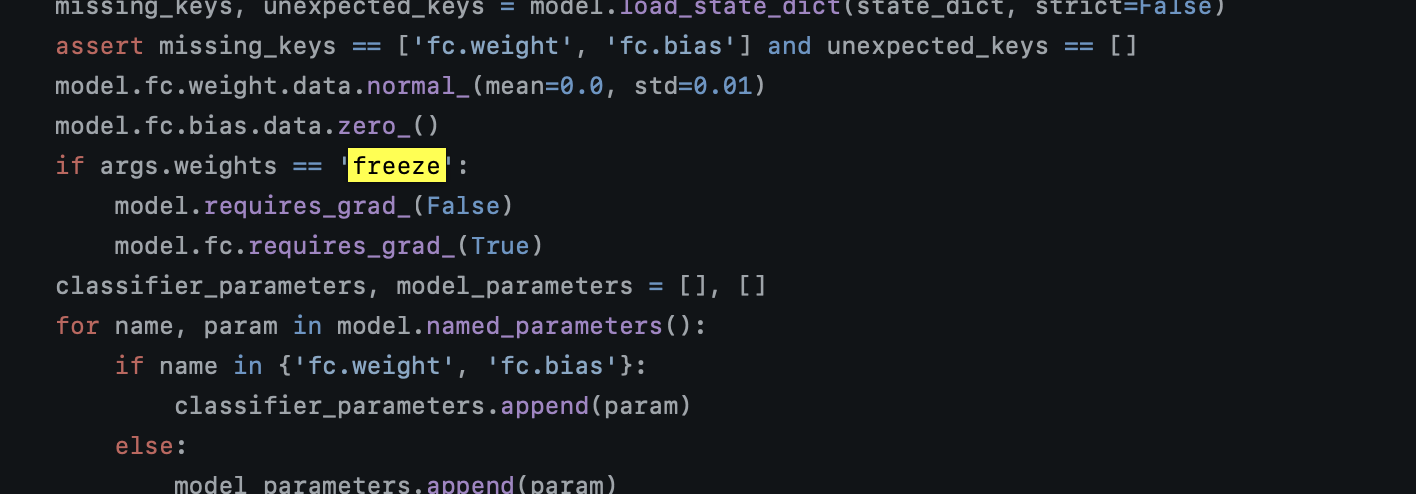


https://github.com/facebookresearch/barlowtwins/blob/8e8d284ca0bc02f88b92328e53f9b901e86b4a3c/evaluate.py#L87
like here, requires grad를 바로 끄고 할 수 있을 듯 

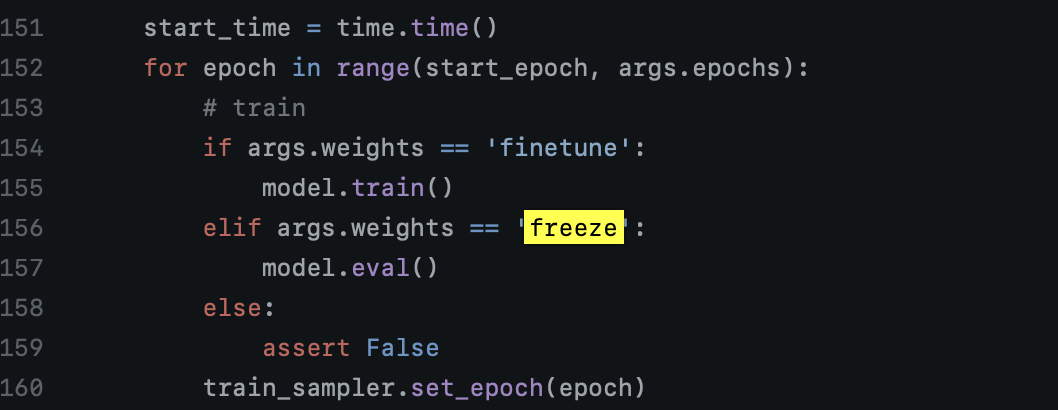

the running avearge chagning because train mode not turned on could also be a major problem => 
* https://discuss.pytorch.org/t/how-to-freeze-bn-layers-while-training-the-rest-of-network-mean-and-var-wont-freeze/89736
* https://discuss.pytorch.org/t/should-i-use-model-eval-when-i-freeze-batchnorm-layers-to-finetune/39495
* https://stackoverflow.com/questions/72899079/what-do-batchnorm2ds-running-mean-running-var-mean-in-pytorch

#### 2.4. Trying with self.model.optimizer thing 


In [68]:
import torch
org_path = "/scratch/connectome/dyhan316/VAE_ADHD/junbeom_finetuning/weights/y-Aware_Contrastive_MRI_epoch_99.pth"
new_path = "/scratch/connectome/dyhan316/VAE_ADHD/junbeom_finetuning/ckpts/ADCN/y-Aware_Contrastive_MRI_epoch_99/y-Aware_Contrastive_MRI_epoch_99_f_10_model.pt"

org = torch.load(org_path)['model'] #여기서는 model을 직접 지정해줘야함!
new = torch.load(new_path)

#match newkeys to old keys

org_list = [i for i in org.keys()]
new_list = [i for i in new.keys()]

print("org list every 100")
print(org_list[-10:])
print("new list every 100 ")
print(new_list[-10:])

print(len(org_list), len(new_list))

##let's look at what makes the two different
print("====what the new ckpt has that the old one doesn't")
#print(set(new_list).difference(org_list))

## comapring the values (after fix!!@)
print("for running_var, kept different (run_var must be set to eval mode I think ): ", torch.std(org['module.features.denseblock4.denselayer16.norm2.running_var'] - new['module.features.denseblock4.denselayer16.norm2.running_var']))
print("for conv weights, kept same (fixing worked!): ",torch.std(org['module.features.denseblock4.denselayer16.conv1.weight'] - new['module.features.denseblock4.denselayer16.conv1.weight']))

org list every 100
['module.features.denseblock4.denselayer16.norm2.weight', 'module.features.denseblock4.denselayer16.norm2.bias', 'module.features.denseblock4.denselayer16.norm2.running_mean', 'module.features.denseblock4.denselayer16.norm2.running_var', 'module.features.denseblock4.denselayer16.norm2.num_batches_tracked', 'module.features.denseblock4.denselayer16.conv2.weight', 'module.hidden_representation.weight', 'module.hidden_representation.bias', 'module.head_projection.weight', 'module.head_projection.bias']
new list every 100 
['module.features.denseblock4.denselayer16.norm2.running_var', 'module.features.denseblock4.denselayer16.norm2.num_batches_tracked', 'module.features.denseblock4.denselayer16.conv2.weight', 'module.features.norm5.weight', 'module.features.norm5.bias', 'module.features.norm5.running_mean', 'module.features.norm5.running_var', 'module.features.norm5.num_batches_tracked', 'module.classifier.weight', 'module.classifier.bias']
724 727
====what the new ckpt 

In [72]:
##running variance : changes


print("======org=====")
print("classifier.weight: doesn't exist")
print("classifier.bias: doesn't exist")
print("cov0.weight : ", torch.std(org['module.features.conv0.weight']))
print("norm2.running_var : ",torch.std(org['module.features.denseblock4.denselayer16.norm2.running_var']))
print("16.conv2.weight : ", torch.std(org['module.features.denseblock4.denselayer16.conv2.weight']))


print("======new=====")
print("classifier.weight: ", torch.std(new['module.classifier.weight']))
print("classifier.bias: ", torch.std(new['module.classifier.bias']))
print("cov0.weight : ", torch.std(new['module.features.conv0.weight']))
print("norm2.running_var : ",torch.std(new['module.features.denseblock4.denselayer16.norm2.running_var']))
print("16.conv2.weight : ", torch.std(new['module.features.denseblock4.denselayer16.conv2.weight']))

======org=====
classifier.weight: doesn't exist
classifier.bias: doesn't exist
cov0.weight :  tensor(0.0768, device='cuda:0')
norm2.running_var :  tensor(0.1218, device='cuda:0')
16.conv2.weight :  tensor(0.0226, device='cuda:0')
======new=====
classifier.weight:  tensor(1.0794, device='cuda:0')
classifier.bias:  tensor(0.0846, device='cuda:0')
cov0.weight :  tensor(0.0768, device='cuda:0')
norm2.running_var :  tensor(0.1150, device='cuda:0')
16.conv2.weight :  tensor(0.0226, device='cuda:0')


In [7]:
print(new['module.features.denseblock1.denselayer1.norm2.num_batches_tracked'])
print(torch.std(new['module.features.denseblock1.denselayer1.norm2.running_mean']))
print((new['module.features.denseblock1.denselayer1.norm2.bias']))

tensor(3, device='cuda:0')
tensor(0.1679, device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


# 위를 보고 우리가 알 수 있는 것 (깨달은 것)
1.  엥... 왜 변하지... ㅠㅠ!! (classifier만 변함, as expected, EXCEPT CIRTICAL PROBELM : RUNNING_VAR(see below))
    
2. `running_var` 이 변하는 것이 문제다! (위에 사이트 보기)
    * running var은 변해도 상관없을수 있지만, 어쨋튼 Batchnorm을 train모드로 사용하면 안됨! (왜냐하면 batch norm이 avg, std들을 update하기에, 그 값들이 eval/downstream task시 변하면 안되서!)

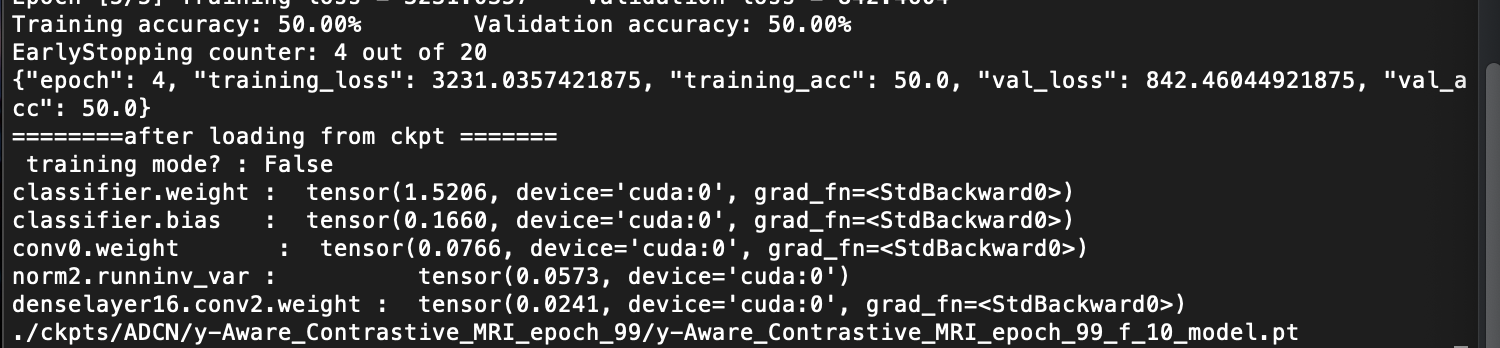

# RECREATING THE ISSUE 1 (LOADING ISSUE) 


#### Recerating using BT weights (this seems to load OK..?)

In [54]:
from yAwareContrastiveLearning.models.densenet import densenet121

In [55]:
org_path = org_pth = "/scratch/connectome/dyhan316/VAE_ADHD/junbeom_finetuning/weights/resnet50_200.pth"


org = torch.load(org_path) #['model'] #여기서는 model을 직접 지정해줘야함!

##loading from dict checkpoint thing 
checkpoint = torch.load(org_path, map_location=lambda storage, loc: storage)


net = densenet121(mode="encoder", drop_rate=0.0)
unexpected = net.load_state_dict(checkpoint, strict= False)

unexpected

_IncompatibleKeys(missing_keys=['hidden_representation.weight', 'hidden_representation.bias', 'head_projection.weight', 'head_projection.bias'], unexpected_keys=[])

In [57]:
checkpoint.keys()

odict_keys(['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var', 'features.norm0.num_batches_tracked', 'features.denseblock1.denselayer1.norm1.weight', 'features.denseblock1.denselayer1.norm1.bias', 'features.denseblock1.denselayer1.norm1.running_mean', 'features.denseblock1.denselayer1.norm1.running_var', 'features.denseblock1.denselayer1.norm1.num_batches_tracked', 'features.denseblock1.denselayer1.conv1.weight', 'features.denseblock1.denselayer1.norm2.weight', 'features.denseblock1.denselayer1.norm2.bias', 'features.denseblock1.denselayer1.norm2.running_mean', 'features.denseblock1.denselayer1.norm2.running_var', 'features.denseblock1.denselayer1.norm2.num_batches_tracked', 'features.denseblock1.denselayer1.conv2.weight', 'features.denseblock1.denselayer2.norm1.weight', 'features.denseblock1.denselayer2.norm1.bias', 'features.denseblock1.denselayer2.norm1.running_mean', 'features.denseblock1.denselayer2

In [53]:
##이제 제대로 된다! ㅎ하하하하핫하하핫 
#단, running_var은 문제이다
org2 = checkpoint#['model']
print("======org2=====")
print("classifier.weight: doesn't exist")
print("classifier.bias: doesn't exist")
print("cov0.weight : ", torch.std(org2['features.conv0.weight']))
print("norm2.running_var : ",torch.std(org2['features.denseblock4.denselayer16.norm2.running_var']))
print("16.conv2.weight : ", torch.std(org2['features.denseblock4.denselayer16.conv2.weight']))


###model-loaded
print("====after being loaded to model====")
print("classifier.weight : ",None)
print("classifier.bias   : ",None)
print("conv0.weight       : ", torch.std(net.features.conv0.weight)) #conv3d 1 64 777 
print("norm2.runninv_var :         ", torch.std(net.features.denseblock4.denselayer16.norm2.running_var))
print("denselayer16.conv2.weight : ", torch.std(net.features.denseblock4.denselayer16.conv2.weight))

print("but in reality, BT weight is not loaded to model, because `model` is not in checkpoint(therefore, still error )")

======org2=====
classifier.weight: doesn't exist
classifier.bias: doesn't exist
cov0.weight :  tensor(0.0760)
norm2.running_var :  tensor(0.4556)
16.conv2.weight :  tensor(0.0242)
====after being loaded to model====
classifier.weight :  None
classifier.bias   :  None
conv0.weight       :  tensor(0.0760, grad_fn=<StdBackward0>)
norm2.runninv_var :          tensor(0.4556)
denselayer16.conv2.weight :  tensor(0.0242, grad_fn=<StdBackward0>)
but in reality, BT weight is not loaded to model, because `model` is not in checkpoint(therefore, still error )


In [34]:
print(hasattr(checkpoint, "state_dict"))   #false
print(isinstance(checkpoint, dict)) #이게 쓰임 
    #if hasattr(checkpoint, "state_dict"):
            #    unexpected = self.model.load_state_dict(checkpoint.state_dict())
            #    self.logger.info('Model loading info: {}'.format(unexpected))
            #elif isinstance(checkpoint, dict):
"model" in checkpoint

False
True


False

#### Recreating using yAware thing (junbeom's weights)

In [58]:
#model to load onto :
from yAwareContrastiveLearning.models.densenet import densenet121
##loading the from ckpt directly
org_path = "/scratch/connectome/dyhan316/VAE_ADHD/junbeom_finetuning/weights/y-Aware_Contrastive_MRI_epoch_99.pth"
org = torch.load(org_path)['model'] #여기서는 model을 직접 지정해줘야함!

##loading from dict checkpoint thing 
checkpoint = torch.load(org_path, map_location=lambda storage, loc: storage)


net = densenet121(mode="encoder", drop_rate=0.0)
unexpected = net.load_state_dict(checkpoint['model'], strict= False)
unexpected

_IncompatibleKeys(missing_keys=['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var', 'features.denseblock1.denselayer1.norm1.weight', 'features.denseblock1.denselayer1.norm1.bias', 'features.denseblock1.denselayer1.norm1.running_mean', 'features.denseblock1.denselayer1.norm1.running_var', 'features.denseblock1.denselayer1.conv1.weight', 'features.denseblock1.denselayer1.norm2.weight', 'features.denseblock1.denselayer1.norm2.bias', 'features.denseblock1.denselayer1.norm2.running_mean', 'features.denseblock1.denselayer1.norm2.running_var', 'features.denseblock1.denselayer1.conv2.weight', 'features.denseblock1.denselayer2.norm1.weight', 'features.denseblock1.denselayer2.norm1.bias', 'features.denseblock1.denselayer2.norm1.running_mean', 'features.denseblock1.denselayer2.norm1.running_var', 'features.denseblock1.denselayer2.conv1.weight', 'features.denseblock1.denselayer2.norm2.weight', 'features.denseblock1.d

In [59]:
len(unexpected.missing_keys) #this is the reason why loaded model weights are very different! 

604

In [60]:
org2 = checkpoint['model']
print("======org2=====")
print("classifier.weight: doesn't exist")
print("classifier.bias: doesn't exist")
print("cov0.weight : ", torch.std(org2['module.features.conv0.weight']))
print("norm2.running_var : ",torch.std(org2['module.features.denseblock4.denselayer16.norm2.running_var']))
print("16.conv2.weight : ", torch.std(org2['module.features.denseblock4.denselayer16.conv2.weight']))


###model-loaded
print("====after being loaded to model====")
print("classifier.weight : ",None)
print("classifier.bias   : ",None)
print("conv0.weight       : ", torch.std(net.features.conv0.weight)) #conv3d 1 64 777 
print("norm2.runninv_var :         ", torch.std(net.features.denseblock4.denselayer16.norm2.running_var))
print("denselayer16.conv2.weight : ", torch.std(net.features.denseblock4.denselayer16.conv2.weight))

======org2=====
classifier.weight: doesn't exist
classifier.bias: doesn't exist
cov0.weight :  tensor(0.0765)
norm2.running_var :  tensor(0.1937)
16.conv2.weight :  tensor(0.0220)
====after being loaded to model====
classifier.weight :  None
classifier.bias   :  None
conv0.weight       :  tensor(0.0765, grad_fn=<StdBackward0>)
norm2.runninv_var :          tensor(0.)
denselayer16.conv2.weight :  tensor(0.0242, grad_fn=<StdBackward0>)


In [61]:
print("======org2=====")
print("classifier.weight: doesn't exist")
print("classifier.bias: doesn't exist")
print("cov0.weight : ", torch.sum(org2['module.features.conv0.weight']))
print("norm2.running_var : ",torch.sum(org2['module.features.denseblock4.denselayer16.norm2.running_var']))
print("16.conv2.weight : ", torch.sum(org2['module.features.denseblock4.denselayer16.conv2.weight']))


###model-loaded
print("====after being loaded to model====")
print("classifier.weight : ",None)
print("classifier.bias   : ",None)
print("conv0.weight       : ", torch.sum(net.features.conv0.weight)) #conv3d 1 64 777 
print("norm2.runninv_var :         ", torch.sum(net.features.denseblock4.denselayer16.norm2.running_var))
print("denselayer16.conv2.weight : ", torch.sum(net.features.denseblock4.denselayer16.conv2.weight))

======org2=====
classifier.weight: doesn't exist
classifier.bias: doesn't exist
cov0.weight :  tensor(-1.2270)
norm2.running_var :  tensor(68.2085)
16.conv2.weight :  tensor(13.2616)
====after being loaded to model====
classifier.weight :  None
classifier.bias   :  None
conv0.weight       :  tensor(-1.7467, grad_fn=<SumBackward0>)
norm2.runninv_var :          tensor(128.)
denselayer16.conv2.weight :  tensor(-0.8613, grad_fn=<SumBackward0>)


In [48]:
print(net.features.denseblock4.denselayer13.norm2.)

<bound method Module.parameters of BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)>


### 3. recreating the issue using toy model 


#### 3.1. Default thing, 

In [77]:
import torch.nn as nn 
from torch.optim import optim
class mymodel(nn.Module):
    def __init__(self):
        super().__init__() 
        self.layer1 = nn.Linear(10, 5)
        self.layer2 = nn.Linear(5,5)
        self.layer3 = nn.Linear(5,5)
        self.layer4 = nn.Linear(2,2) #shouldn't change
        self.act = nn.Sigmoid()
    def forward(self, x):
        x = self.layer1(x) 
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.act(x)
        return x
model = mymodel()

name_list = []
for name, weight in model.named_parameters():
    name_list.append(name)


weights = []

for param in model.parameters():
    weights.append(param.clone())

criterion = nn.BCELoss() # criterion and optimizer setup
optimizer = optim.Adam(model.parameters(), lr=0.001)

foo = torch.randn(3, 10) # fake input
target = torch.randn(3, 5) # fake target

result = model(foo) # predictions and comparison and backprop
loss = criterion(result, target)
optimizer.zero_grad()
loss.backward()
optimizer.step()


weights_after_backprop = [] # weights after backprop
for param in model.parameters():
    weights_after_backprop.append(param.clone()) # only layer1's weight should update, layer2 is not used


print("are they the same?")
for num,i in enumerate(zip(weights, weights_after_backprop)):
    print(name_list[num], " : ", torch.equal(i[0], i[1]))

NameError: name 'optim' is not defined

In [76]:
weights[0] == weights_after_backprop[0]

NameError: name 'weights' is not defined

#### 3.2. Seeing if junbeom finetune code is OK => 결론 : NO

In [159]:
weights = []

for param in model.parameters():
    weights.append(param.clone())

####NEW THING 
criterion = nn.BCELoss() # criterion and optimizer setup
finetune_1_optimizer = optim.Adam(model.layer2.parameters(), lr=0.001)

foo = torch.randn(3, 10) # fake input
target = torch.randn(3, 5) # fake target

result = model(foo) # predictions and comparison and backprop
loss = criterion(result, target)
print(next(model.layer3.parameters()).requires_grad) #requires grad is true
finetune_1_optimizer.zero_grad()
print(next(model.layer3.parameters()).requires_grad)
loss.backward()
print(next(model.layer3.parameters()).requires_grad)
finetune_1_optimizer.step()


weight_finetune_1 = [] # weights after backprop
for param in model.parameters():
    weight_finetune_1.append(param.clone()) # only layer1's weight should update, layer2 is not used

print("are they the same?")
for num,i in enumerate(zip(weights, weight_finetune_1)):
    print(name_list[num], " : ", torch.equal(i[0], i[1]))

True
True
True
are they the same?
layer1.weight  :  True
layer1.bias  :  True
layer2.weight  :  False
layer2.bias  :  False
layer3.weight  :  True
layer3.bias  :  True
layer4.weight  :  True
layer4.bias  :  True


In [112]:
for i, hi in enumerate(zip([1,2],[3,4])):
    print(i, hi)

0 (1, 3)
1 (2, 4)


In [148]:
next(model.layer1.parameters())

Parameter containing:
tensor([[ 0.1114, -0.2612,  0.0009, -0.2694,  0.1402,  0.1748,  0.0770, -0.1588,
         -0.0275, -0.0788],
        [ 0.1138, -0.0238,  0.0246,  0.0145, -0.1742,  0.0327, -0.1760, -0.1619,
         -0.0004, -0.0013],
        [ 0.0156, -0.0769, -0.2812,  0.1227,  0.0750,  0.0265, -0.0091,  0.2753,
          0.0792, -0.0697],
        [-0.1086,  0.0239,  0.2965,  0.1133, -0.2217,  0.1357, -0.0506,  0.1628,
          0.1302,  0.0067],
        [-0.0438,  0.0906, -0.1351, -0.0120,  0.1435,  0.0323,  0.2898, -0.1436,
          0.0983, -0.0322]], requires_grad=True)

### 3. recreating the issue using toy model => trash right now, (위에꺼가 더 잘된다)

### 그냥 위에있는 BT용 그거 바로보기!

In [71]:
import torchvision
import os 
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
from barlowtwins.models import densenet

#model = densenet.densenet121(mode = "barlow_encoder", drop_rate = 0.0, num_classes = 2 )
        
        

In [72]:
from torch.utils.data import DataLoader
from torchvision import datasets 
from torchvision.transforms import ToTensor #to go from image to tensor I believe



####1. instantiate DataSet!#####
train_data = datasets.MNIST(
    train = True, #the only thing different with test_data, specfieis that we want training dataset
    root = "data",
    download = True,
    transform = ToTensor() #import as torch tensor
)

test_data = datasets.MNIST(
    train = False, #the only thing different with test_data, specfieis that we want training dataset
    root = "data",
    download = True,
    transform = ToTensor() #import as torch tensor
)


####2. instantiate DataLoader (using previously defined dataset)#####
batch_size_to_use = 64 #arguments for DataLoader
train_loader = DataLoader(train_data, batch_size = batch_size_to_use , shuffle = True)
test_loader = DataLoader(test_data, batch_size= batch_size_to_use, shuffle=True)

In [73]:
import torch.nn as nn 
import torch.nn.functional as F #module that has lots of functions that are frequently used (ex : sigmoid, relu, etc)

class custom_NN(nn.Module):
    def __init__(self):
        super(custom_NN, self).__init__() # bring attributes from nn.Module into this 이것 없으면 안됨!
        self.fc1 = nn.Linear(28*28, 128) #28*28 : sample size, 128 : hidden layer size
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4_final = nn.Linear(64, 10) #10 : # of classes
        
    def forward(self, x): # x : input!
        x = x.reshape(-1, 784) #shape : (1,784) => ASK why not [784] 안쓰고 [1,784]?
        #x = x.flatten() #이렇게 하면 애러난다! (shape : (784)) => ask why
        x = F.relu(self.fc1(x)) #use F.relu method (matrix multiplication then relu func)
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = self.fc4_final(x) #final layer, don't apply nonlinear func, just linear combination
        return x 
        #option 2 : nn.Sequential (look at my original collab notes)

#instantiate the custom model!
network = custom_NN()  # this will be used kinda like the "model" in sklearn

In [74]:
def train(model, optim, loss_fn, train_loader, epochs, device):
    #let's run the training
    for epoch in range(epochs):
        train_loss = 0.0
        model.train() #TURN TRAINING MODE ON
        for batch in train_loader:
            input_tensor, target = batch #get data
            input_tensor = input_tensor.to(device) #send to GPU 
            target = target.to(device)

            #computing gradient using Autograd engine
            optim.zero_grad()  #initialize
            output = model(input_tensor) 
            loss = loss_fn(output, target) 
            loss.backward()
            optim.step()
            train_loss += loss.data.item() #compute loss (i guess this is also an instance of using preexisting attribuet of loss?)
        train_loss /= len(train_loader.dataset) #i.e. normalize training loss
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss}')
        #print("===showing that the loss computed during training is just another Tensor, just with `requires_grad = True`===\n",
              #type(loss), loss.requires_grad) 

In [80]:
import torch
import torch.optim as optim

#optimizer, loss_fn and other setting (arguments of the trainining loop function)
optimizer = optim.Adam(network.parameters(), lr=1.0) #i.e. parameters of custom NN as input, 
loss_function = nn.CrossEntropyLoss()
train_loader = train_loader #이미 정의했었다
num_epochs = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
print(device)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network.to(device)


train(model = network, optim = optimizer, loss_fn = loss_function,
     train_loader = train_loader, epochs = num_epochs, device = device)

cuda:0
Epoch: 1, Training Loss: 0.10502868146498998


https://stackoverflow.com/questions/51717874/why-is-it-in-pytorch-when-i-make-a-copy-of-a-networks-weight-it-would-be-automa

In [82]:
org_weights = []
for name, weight in enumerate(network.parameters()):
    print(name, weight.shape)
    org_weights.append(weight.clone()) #.data and .clone becaue or else, they're linked (not deep copy)

train(model = network, optim = optimizer, loss_fn = loss_function,
     train_loader = train_loader, epochs = 1, device = device)

new_weights = []
for name, weight in enumerate(network.parameters()):
    print(name, weight.shape)
    new_weights.append(weight.clone())#.item())



0 torch.Size([128, 784])
1 torch.Size([128])
2 torch.Size([128, 128])
3 torch.Size([128])
4 torch.Size([64, 128])
5 torch.Size([64])
6 torch.Size([10, 64])
7 torch.Size([10])


/home/connectome/dyhan316/.local/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1, Training Loss: 0.10039142954349518
0 torch.Size([128, 784])
1 torch.Size([128])
2 torch.Size([128, 128])
3 torch.Size([128])
4 torch.Size([64, 128])
5 torch.Size([64])
6 torch.Size([10, 64])
7 torch.Size([10])


In [86]:
torch.equal(org_weights[0], new_weights[0])

True

In [62]:
type(org_weights[1])

torch.Tensor

example data shape :  torch.Size([64, 1, 28, 28])
example target shape :  torch.Size([64])


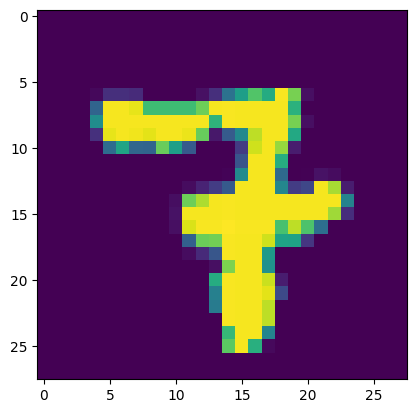

In [12]:
###looking at one example###
import matplotlib.pyplot as plt

##왜 이렇게 작동하는지 지금은 잘 모르겠다... for now, just roll with it
examples = enumerate(test_loader) 

batch_idx , (example_data, example_targets) = next(examples)

print("example data shape : ", example_data.shape) #[64,1,28,28] : batch size of 64, color of 1, 28*28 image (I think)
print("example target shape : ", example_targets.shape)

#look at first sample of the batch 
plt.imshow(example_data[0].squeeze()) 

In [15]:
os.listdir('data/MNIST')

['raw']

### 4. fixing the issue by referencing other stuff 